In [1]:
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [2]:
def BKS(z,x,zeta,sigma,sq_sigma_n=None):
    #写像の推定
    Dist = dist.cdist(zeta, z, 'sqeuclidean')
    H = np.exp(-0.5*Dist/(sigma*sigma))
    g = H.sum(axis=1)[:, np.newaxis]
    ginv = np.reciprocal(g)
    R = H * ginv
    f = R @ x
    
    #分散の推定
    if sq_sigma_n is None:
        Distzz = dist.cdist(z, z, 'sqeuclidean')
        Hzz = np.exp(-0.5*Distzz/(sigma*sigma))
        gzz = Hzz.sum(axis=1)[:, np.newaxis]
        ginvzz = np.reciprocal(gzz)
        Rzz = Hzz * ginvzz
        y = Rzz @ x
        x2 = np.diag(x@x.T)[:,np.newaxis]
        y2 = np.sum(np.square(y),axis=1)[:,np.newaxis]
        beta0 = np.sum(gzz) / np.sum(gzz * (x2 - y2))
        print('none')
    else:
        beta0 = 1 / sq_sigma_n
        print('not none')
    fcov = beta0 * ginv
    
    return f,fcov

In [3]:
#parameter
nb_samples = 100
seed = 1
sq_sigma_n = 0.1

#prepare artificial data
np.random.seed(seed)
z = (np.random.rand(nb_samples,1) - 0.5)*2*np.pi
zeta = np.linspace(-np.pi,np.pi,1000)[:,np.newaxis]
x = np.sin(z)+np.random.normal(0.0,sq_sigma_n,(nb_samples,1))

まずは観測データの分散$\sigma_n^2$を自動推定せずにやってみる

not none


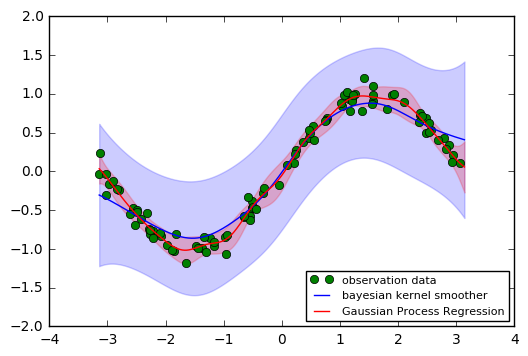

In [4]:
#parameter
sigma_bks = 0.5
sigma_gp = 0.5 / np.sqrt(2)

#BKSによるフィッティング
f_bks,fcov_bks = BKS(z,x,zeta,sigma_bks,sq_sigma_n)
plt.plot(z,x,'go',label='observation data')
plt.plot(zeta,f_bks,'b-',label='bayesian kernel smoother')
plt.fill_between(zeta.ravel(), f_bks.ravel() - np.sqrt(fcov_bks.ravel()),
                 f_bks.ravel() + np.sqrt(fcov_bks.ravel()),
                 alpha = 0.2, color='b')

kernel = 1.0 * RBF(length_scale=sigma_gp, length_scale_bounds=(sigma_gp, sigma_gp))
gp = GaussianProcessRegressor(kernel=kernel,alpha=sq_sigma_n,optimizer=None).fit(z, x)
f_gp,fcov_gp = gp.predict(zeta,return_cov=True)
plt.plot(zeta,f_gp,'r-',label='Gaussian Process Regression')
plt.fill_between(zeta.ravel(), f_gp.ravel() - np.sqrt(np.diag(fcov_gp)),
                 f_gp.ravel() + np.sqrt(np.diag(fcov_gp)), alpha=0.2, color='r')#透明な赤
plt.legend(fontsize=8,loc="lower right",frameon=True)
plt.show()

In [7]:
fcov_gp.mean()

0.0012088223841250287

In [8]:
fcov_bks.mean()

0.5485599794366588